# Catan Analysis
By Jack Higgins

## To Do
- [x] Add in harbors to code
- [x] Refactor graphical code
- [x] Check graphical code works
- [ ] Convert np.array([q,r]) to hex(q,r)
- [ ] Fix spelling lol
- [ ] Document code (docstrings + type annotations)

In [1]:
import numpy as np
from __future__ import annotations
from math import sin, cos, pi, sqrt
from dataclasses import dataclass, field
from random import randint, shuffle, seed
import drawSvg as draw

seed(2022)

## Creating the board

In [2]:
availible_hex_types = (4 * [1] + 
         4 * [2] + 
         4 * [3] + 
         3 * [4] + 
         3 * [5] + 
         1 * [0])

availible_tokens = (1 * [0] +
      1 * [2] + 
      2 * [3] + 
      2 * [4] + 
      2 * [5] + 
      2 * [6] + 
      2 * [8] + 
      2 * [9] + 
      2 * [10] + 
      2 * [11] + 
      1 * [12])

availible_harbors = (1 * [1] + 
                1 * [2] + 
                1 * [3] + 
                1 * [4] +
                1 * [5] + 
                4 * [0])

harbor_locations = [ # Specified using the vertex encoding
    [[-1,  3,  0], [-1,  2,  1]],
     [[-2,  2,  1], [-3,  3,  0]],
     [[-3,  2,  0], [-2,  0,  1]],
     [[-2,  0,  0], [-1, -2,  1]],
     [[ 0, -3,  1], [ 0, -2,  0]],
     [[ 1, -2,  0], [ 2, -3,  1]],
     [[ 2, -1,  0], [ 3, -2,  1]],
     [[ 3, -1,  1], [2, 1, 0]],
     [[1, 2, 0], [1, 1, 1]]
]

### Symbolic representation

In [20]:
def calc_number_hexes(radius: int) -> int:
    return 1 + 3 * radius * (radius + 1)

def h(q,r):
    return np.array([q,r])

def p(x,y):
    return np.array([x,y])
    

def create_hex_mapping(radius):
    """
    Returns a list of hex co-ordinates in a hexagonal grid of the given radius
    """
    num_hexes = calc_number_hexes(radius)
    i = 0
    hex_map = np.zeros(shape = (num_hexes, 2), dtype = np.int8)
    for q in range(-radius, radius + 1):
        r1 = max(-radius, -q - radius)
        r2 = min(radius, -q + radius)
        for r in range(r1, r2 + 1):
            hex_map[i] = h(q, r)
            i += 1
            
    return hex_map

def hex_coords_to_grid_index(hex_, hex_grid):
     return(np.where(np.all(hex_coords_map == hex_, axis = 1))[0][0])

def check_availible_features(num_hexes, hex_types, tokens):
    """
    Quick QC function to check if the number of hex_types, tokens 
    and ports is correct. 
    """
    if len(hex_types) != num_hexes: print("ERROR: num_hexes != len(hex_types)")
    if len(tokens) != num_hexes: print("ERROR: num_hexes != len(tokens)")
    
def assign_hex_types(availible_hex_types: ndarray[int], desert_center = False) -> ndarray[int]:
    """
    Assigns a terrain type to each hex coordinate
    """
    hex_terrains = np.random.permutation(availible_hex_types)
    
    if desert_center is True:
        desert_index = list(hex_terrains).index(0)
        # Center token is always generated as the middle index in the list
        center_index = (len(availible_tokens) - 1)//2
        hex_terrains[[desert_index, center_index]] = hex_terrains[[center_index, desert_index]]
    
    return hex_terrains

def assign_tokens(availible_tokens: ndarray[int], board_hex_types: ndarray[int]) -> ndarray[int]:
    """
    Assigns token to hexes
    Need to ensure that the 'zero' token is on the desert hex.
    """
    token_assignment = np.random.permutation(availible_tokens)
    desert_index = list(board_hex_types).index(0)
    token_zero_index = list(token_assignment).index(0)
    # Swap
    token_assignment[[desert_index, token_zero_index]] = token_assignment[[token_zero_index, desert_index]]
    return token_assignment


def assign_harbors(availible_harbors: ndarray[int]) -> ndarray[int]:
    harbor_assignment = np.random.permutation(availible_harbors)
    return harbor_assignment


def pad_array(A, size):
    d = size - len(A)
    return np.pad(A, pad_width=(0, d), mode='constant', constant_values=-1)

# np.array
def create_random_board(radius: int, 
                        availible_hex_types: ndarray[int], 
                        availible_tokens: ndarray[int],
                        availible_harbors,
                        desert_center = False) -> ndarray:
    hex_types = assign_hex_types(availible_hex_types, desert_center)
    tokens = assign_tokens(availible_tokens, hex_types)
    harbors = assign_harbors(availible_harbors)
    harbors_padded = padarray(harbors, len(hex_types))
    board = np.array((hex_types, tokens, harbors_padded))
    return board


def create_n_random_boards(n: int,
                           radius: int, 
                           availible_hex_types: ndarray[int], 
                           availible_tokens: ndarray[int],
                           availible_harbors,
                           desert_center = False) -> ndarray:
    num_hexes = calc_number_hexes(radius)
    boards = np.zeros((n, 3, num_hexes), dtype = int)
    for i in range(n):
        board = create_random_board(radius, availible_hex_types, availible_tokens, availible_harbors, desert_center)
        boards[i] = board
        
    return(boards)

In [5]:
# Generate boards
radius = 2
desert_center = False
n = int(1e6)
boards_file = 'boards_1e6.npy'
# boards = create_n_random_boards(n, radius, availible_hex_types, availible_tokens, availible_harbors, desert_center)
# np.save(boards_file, boards)

In [6]:
# Load boards
boards = np.load(boards_file)

### Old hex stuff

In [7]:
@dataclass
class Hex:
    """Implements a discrete hexagonal co-ordinate system.
    
    Three axes, q, r and s are used. Each location in the system satisfies 
    the constraint q + r + s = 0, so we don't need to request all three as
    input, as the third can be calculated (e.g. s = -q - r). 
    
    See www.redblobgames.com/grids/hexagons/ for more details on hexagonal
    co-ordinate systems.
    
    Attributes:
        q: An int denoting the hexagon's coordinate along the q axis.
        r: An int denoting the hexagon's coordinate along the r axis.
        s: An int denoting the hexagon's coordinate along the s axis.
    """
    
    q: int
    r: int
    s: int = field(init=False)
    
    def __post_init__(self):
        self.s = -self.q - self.r

    def __eq__(self, other):
        return self.q == other.q and self.r == other.r
    
    def __add__(self, other):
        return Hex(self.q + other.q, self.r + other.r)
    
    def __hash__(self):
        return hash((self.q, self.r))

old_harbor_locations = [  # Vertices are defined by hex triples
    ((Hex(0,2), Hex(-1, 2), Hex(-1,3)), (Hex(-1,2), Hex(-1,3), Hex(-2,3))),
    ((Hex(-2,2), Hex(-2,3), Hex(-3,3)), (Hex(-2,2), Hex(-3,3), Hex(-3,2))),
    ((Hex(-2,1), Hex(-3,2), Hex(-3,1)), (Hex(-2,1), Hex(-2,0), Hex(-3,1))),
    ((Hex(-2,0), Hex(-1,-1), Hex(-2,-1)), 
     (Hex(-1,-2), Hex(-1,-1), Hex(-2,-1))),
    ((Hex(0,-2), Hex(-1,-2), Hex(0,-3)), (Hex(0,-2), Hex(0,-3), Hex(1,-3))),
    ((Hex(1,-2), Hex(1,-3), Hex(2,-3)), (Hex(1,-2), Hex(2,-3), Hex(2,-2))),
    ((Hex(2,-1), Hex(2,-2), Hex(3,-2)), (Hex(2,-1), Hex(3,-2), Hex(3,-1))),
    ((Hex(2,0), Hex(3,0), Hex(3,-1)), (Hex(2,0), Hex(3,0), Hex(2,1))),
    ((Hex(1,1), Hex(1,2), Hex(2,1)), (Hex(1,1), Hex(1,2), Hex(0,2)))
]

def get_vertices(h):
    q, r = h.q, h.r
    vertices = [
        Vertex(q, r, 't'), 
        Vertex(q, r + 1, 'b'),
        Vertex(q + 1, r - 1, 't'),
        Vertex(q, r, 'b'),
        Vertex(q, r - 1, 't'),
        Vertex(q - 1, r + 1, 'b')
    ]
    return vertices

# print(get_vertices(Hex(0,0)))

def vertex_to_hex_trip(v):
    q, r, d = v.q, v.r, v.d
    h1 = Hex(q,r)
    if d == 't':
        h2, h3 = Hex(q - 1, r + 1), Hex(q, r + 1)
    else:
        h2, h3 = Hex(q + 1, r - 1), Hex(q, r - 1)
    return [h1, h2, h3]


def hex_trip_to_vertex(hex_trip):
    """
    Converts hex trip to vertex
    """
    h1, h2, h3 = hex_trip
    r_list = [h1.r, h2.r, h3.r]
    base_hex_r = [r for r in r_list if r_list.count(r)==1][0]
    base_hex_ind = r_list.index(base_hex_r)
    base_hex = hex_trip[base_hex_ind]
    q, r = base_hex.q, base_hex.r
    if base_hex.r > hex_trip[base_hex_ind - 1].r:
        d = 0 # 'b'
    else:
        d = 1 # 't'

    return np.array([q, r, d])

print(hex_trip_to_vertex(harbor_locations[0][1]))


harbor_locations = []
for vert_pair in harbor_locations:
    pair = []
    for vert in vert_pair:
        pair.append(hex_trip_to_vertex(vert))
    new_harbor_locations.append(pair)
        
harbor_locations
                                     

[-1  2  1]


[[array([-1,  3,  0]), array([-1,  2,  1])],
 [array([-2,  2,  1]), array([-3,  3,  0])],
 [array([-3,  2,  0]), array([-2,  0,  1])],
 [array([-2,  0,  0]), array([-1, -2,  1])],
 [array([ 0, -3,  1]), array([ 0, -2,  0])],
 [array([ 1, -2,  0]), array([ 2, -3,  1])],
 [array([ 2, -1,  0]), array([ 3, -2,  1])],
 [array([ 3, -1,  1]), array([2, 1, 0])],
 [array([1, 2, 0]), array([1, 1, 1])]]

In [8]:
hex_coord_map = create_hex_mapping(radius = 2)
hex_type_map = np.array(['desert', 'grain', 'lumber', 'wool', 'brick', 'ore'])
harbor_type_map = np.array(['generic', 'grain', 'lumber', 'wool', 'brick', 'ore'])

In [9]:
create_random_board(2, availible_hex_types, availible_tokens, availible_harbors, desert_center = True)

array([[ 4,  3,  4,  3,  2,  3,  1,  1,  5,  0,  3,  5,  2,  1,  4,  1,
         2,  5,  2],
       [10,  3,  8,  6, 11,  4, 11,  9,  4,  0,  9,  2,  5,  3,  5,  6,
        12, 10,  8],
       [ 0,  3,  0,  0,  5,  2,  4,  1,  0, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1]])

### Graphical representation

#### New

In [25]:
def rotate(point, angle: float, origin = np.array([0,0])):
    """Rotates a two dimensional point by a given angle about another point.
    """
    i = point
    o = origin
    a = angle
    del_x = i[0] - o[0]
    del_y = i[1] - o[1]
    x = o[0] + del_x * cos(a) - del_y * sin(a)
    y = o[1] + del_x * sin(a) + del_y * cos(a)
    return p(x,y)


def hex_to_center_pixel(hex_, size: float):
    """Converts hex coords to a single xy coord denoting the hex's center.
    """
    q, r = hex_
    
    x = size * (sqrt(3) * q + sqrt(3)/2 * r)
    y = size * (3/2 * r)
    return p(x,y)


def hex_to_vertex_pixels(hex_, size: float):
    """Converts hex coords to six xy coords denoting the hex's vertices.
    """
    center = hex_to_center_pixel(hex_, size)
    p1 = center + np.array([0, size])
    angles = [pi/3 * x for x in range(6)]
    return np.array([rotate(p1, angle, center) for angle in angles])

def hex_intersection_to_vertex_pixel(hex_trip):
    """Converts 3 hex coords to a single xy coord denoting their shared vertex.
    """
    h1, h2, h3 = hex_trip
    c1 = hex_to_center_pixel(h1, 50)
    c2 = hex_to_center_pixel(h2, 50)
    c3 = hex_to_center_pixel(h3, 50)
    vertex = p((c1[0] + c2[0] + c3[0])/3, (c1[1] + c2[1] + c3[1])/3)
    return vertex

def roll_freq(value: int):
    """ Returns the relative frequency of a value being rolled by two dice.
    
    Returns the number of ways a value, between 2 and 12 inclusive, can be
    rolled by two, standard six sided die.
    
    Args:
        value: An int between 2 and 12.
    
    Return:
        rel_freq: An int, the number of different ways to roll value.
    """
    assert value >= 2 and value <= 12
    rel_freq = 6 - abs(7 - value)
    return rel_freq


def init_canvas(width, height):
    """ Initialise the SVG canvas on which to draw the board.
    """
    d = draw.Drawing(width, height, origin='center')
    return d


def draw_background(d):
    """ Draw the background/water hex.
    """
    origin = p(0,0)
    vertex_coords = hex_to_vertex_pixels(origin, hex_size * 5.8)
    for i in range(len(vertex_coords)):
        vertex_coords[i] = rotate(vertex_coords[i], pi/6)
    vertex_coords = vertex_coords.flatten()

    d.append(draw.Lines(*vertex_coords,close=True,
                            fill=hex_colours['water'],
                            stroke=stroke_colour, stroke_width=stroke_width), z=0)
    
    
def draw_board_outline(d, hex_grid):
    """ Draw a plain outline of the board.
    """
    for hex_ in hex_grid:
        vertex_coords = hex_to_vertex_pixels(hex_, hex_size).flatten()
        d.append(draw.Lines(*vertex_coords,
                            close=True,
                            fill='#FFFFFF',
                            stroke=stroke_colour, 
                            stroke_width=stroke_width,
                            coords = hex_
                           ),
                z=1)

        
def fill_board(d, hex_grid, board):
    """ Fill the board hexes with their type colours.
    """
    for element in d.allElements():
        try:
            hex_ = element.args['coords']
            ind = hex_coords_to_grid_index(hex_, hex_grid)
            hex_type = board[0][ind]
            fill_colour = hex_colours[hex_type_map[hex_type]]
            element.args['fill'] = fill_colour
        except KeyError: 
            pass

        
def draw_tokens(d, hex_grid, board, show_dots=True):
    """ Draw each hexes token on the board.
    """
    
    radius = 25
    
    for hex_ in hex_grid:
        center = hex_to_center_pixel(hex_, hex_size)
        ind = hex_coords_to_grid_index(hex_, hex_grid)
        hex_token = board[1][ind]
        if hex_token != 0:
            if hex_token == 6 or hex_token == 8:
                token_colour = token_text_colour[0]
            else:
                token_colour = token_text_colour[1]
            font_size = 31 - 2.5 * abs(7 - hex_token)

            d.append(draw.Circle(center[0], center[1], 
                                 r=radius, fill=token_fill_colour), 
                     z=2)

            if show_dots: 
                vert_off = 3 
            else: 
                vert_off = 0

            d.append(draw.Text(str(hex_token), fontSize=font_size, 
                               x=center[0], y=center[1] + vert_off, center=True, 
                               valign = 'middle', font_family = font_family, 
                               fill = token_colour, font_weight = 'bold'),
                     z=3)

            if show_dots:
                r = 1.6
                num_dots = roll_freq(hex_token)
                dots = []
                if num_dots % 2 == 0:
                    for i in range(1, num_dots // 2 + 1):
                        x_del = 3*r/2 + (i - 1) * 3 * r
                        dots.append(center + p(x_del, - 15))
                        dots.append(center + p(-x_del, - 15))

                else:
                    for i in range(0, num_dots // 2 + 1):
                        x_del = 3 * r * i
                        dots.append(center + p(x_del, - 15))
                        if x_del != 0:
                            dots.append(center + p(-x_del, - 15))

                for dot in dots:
                    d.append(draw.Circle(dot[0], dot[1], r, 
                                         fill = token_colour), z=3)
        

def draw_coords(d, hex_grid):
    """Display the coords of each hex on the board. 
    """
    for hex_ in hex_grid:
        center = hex_to_center_pixel(hex_, hex_size)
        d.append(draw.Text(str(hex_), fontSize=18, 
                   x=center[0], y=center[1], center=True, 
                   valign = 'middle', font_family = "Open Sans", 
                   fill = 'black'), 
                 z=2)

def vertex_to_hex_trip(v):
    q, r, d = v
    h1 = h(q,r)
    if d == 1:
        h2, h3 = h(q - 1, r + 1), h(q, r + 1)
    else:
        h2, h3 = h(q + 1, r - 1), h(q, r - 1)
    return np.array([h1, h2, h3])


def draw_harbors(d, harbor_locations, board, simple=False):
    """Draw the harbors onto the board.
    """
    for i in range(len(harbor_locations)):
        vertex_pair = harbor_locations[i]
        hex_trip_0 = vertex_to_hex_trip(vertex_pair[0])
        hex_trip_1 = vertex_to_hex_trip(vertex_pair[1])
        p1 = hex_intersection_to_vertex_pixel(hex_trip_0)
        p2 = hex_intersection_to_vertex_pixel(hex_trip_1)
        p3 = rotate(p1, pi/3, p2)
        harbor_type = board[2][i]
        fill = harbor_colours[harbor_type]
        ratio = 3 if harbor_type == 'generic' else 2
        if not simple:
            harbor_fill = token_fill_colour
            d.append(draw.Text(f'{ratio}:1',
                               fill=fill, 
                               fontSize=12, 
                               font_family=font_family,
                               font_weight='bold', 
                               x=p3[0], y=p3[1], center=True, valign = 'middle'), 
                     z = 4)
        else:
            harbor_fill = fill
        
        d.append(draw.Circle(p3[0], p3[1], r=13, 
                     fill=harbor_fill, fill_opacity=1, 
                     stroke=fill, stroke_width=4), z=3)
        d.append(draw.Line(p1[0], p1[1], p3[0], p3[1], 
                           stroke = 'black', stroke_width=3,
                           stroke_opacity = 0.5), z=1)
        d.append(draw.Line(p2[0], p2[1], p3[0], p3[1], 
                           stroke ='black', stroke_width=3, 
                           stroke_opacity = 0.5), z=1)

        
def draw_complete_board(board, width, height, simple=False):
    """Draw the board, wrapper function.
    """
    show_dots = False if simple else True
    d = init_canvas(width, height)
    draw_background(d)
    draw_board_outline(d, board)
    fill_board(d, board)
    draw_tokens(d, board, show_dots=show_dots)
    draw_harbors(d, board, simple=simple)
    return d

In [17]:
width = 600
height = width
hex_size = 50
hex_colours = {
    'wool': '#a7c957',
    'grain': '#DFB853',
    'lumber': '#20703D',
    'ore': '#969696',
    'brick': '#C37C3A',
    'desert': '#DCBB96',
    'water': '#B9E3F3'
}
token_fill_colour = "#FFEDD0"
token_text_colour = ("#BD0000", "#100C08")
harbor_colours = { # Darker shades of hex_colours
    1: '#D9A82E',
    2: '#1B5F34',
    3: '#93B93C',
    4: '#A86B32',
    5: '#969696',
    0: '#2A1B0D'
}
font_family = "Open Sans"
stroke_colour = "#100C08"
stroke_width = 3

In [10]:
radius =  2
num_hexes = calc_number_hexes(radius)
hex_coords_map = create_hex_mapping(radius)
hex_type_map = np.array(['desert', 'grain', 'lumber', 'wool', 'brick', 'ore'])

In [15]:
board = boards[0]

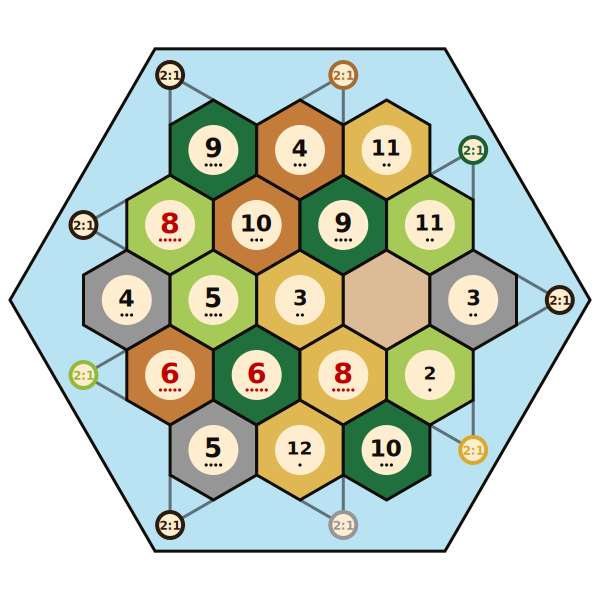

In [26]:
d = init_canvas(width, height)
draw_background(d)
draw_board_outline(d, hex_coords_map)
fill_board(d, hex_coords_map, board)
draw_tokens(d, hex_coords_map, board, show_dots=True)
draw_harbors(d, harbor_locations, board, simple=False)
d

#### Old

In [49]:
@dataclass
class Point:
    """Implements two dimensional points.
    
    Attributes:
        x: A float denoting the point's coordinate along the x axis.
        y: A float denoting the point's coordinate along the y axis.
    """
    
    x: float
    y: float
    
@dataclass
class Hex:
    """Implements a discrete hexagonal co-ordinate system.
    
    Three axes, q, r and s are used. Each location in the system satisfies 
    the constraint q + r + s = 0, so we don't need to request all three as
    input, as the third can be calculated (e.g. s = -q - r). 
    
    See www.redblobgames.com/grids/hexagons/ for more details on hexagonal
    co-ordinate systems.
    
    Attributes:
        q: An int denoting the hexagon's coordinate along the q axis.
        r: An int denoting the hexagon's coordinate along the r axis.
        s: An int denoting the hexagon's coordinate along the s axis.
    """
    
    q: int
    r: int
    s: int = field(init=False)
    
    def __post_init__(self):
        self.s = -self.q - self.r

    def __eq__(self, other):
        return self.q == other.q and self.r == other.r
    
    def __add__(self, other):
        return Hex(self.q + other.q, self.r + other.r)
    
    def __hash__(self):
        return hash((self.q, self.r))
    

def rotate(point: Point, angle: float, origin: Point=Point(0, 0)) -> Point:
    """Rotates a two dimensional point by a given angle about another point.
    
    Args:
        point: A Point, the point to rotate.
        angle: A float, the angle, in radians, to rotate point by.
        origin: A Point, the point by which to center the rotation around.
        
    Return:
        p_r: A Point, the image of point under the specified rotation.
    """
    
    p = point
    o = origin
    a = angle
    del_x = p.x - o.x
    del_y = p.y - o.y
    x = o.x + del_x * cos(a) - del_y * sin(a)
    y = o.y + del_x * sin(a) + del_y * cos(a)
    p_r = Point(x, y)
    return p_r


def hex_to_center_pixel(hex_: Hex, size: float) -> Point:
    """Converts hex coords to a single xy coord denoting the hex's center.
    
    To render the hexes on a screen, conversion between hex co-ordinates and two 
    dimensional cartesian coordinates is required. This function converts the
    coords of the given hex to a single 2D point, which denotes the location
    of the center of the hex in the cartesian coordinate system. 
    
    Args:
        hex_: A Hex, the hex to calculate the center coord of.
        size: A float, the length, in pixels, of the sides hex rendering.
        
    Return:
        center: A Point, the center of the hex to be rendered.
    """
    
    x = size * (sqrt(3) * hex_.q + sqrt(3)/2 * hex_.r)
    y = size * (3/2 * hex_.r)
    center = Point(x,y)
    return center


def hex_to_vertex_pixels(hex_: Hex, size: float) -> list[Point]:
    """Converts hex coords to six xy coords denoting the hex's vertices.
    
    Similar to hex_to_center_pixel(), but calculates coords of the vertices
    instead of the coords of the center.
    
    Args:
        hex_: A Hex, the hex to calculate the vertex coords of.
        size: A float, the length, in pixels, of the sides hex rendering.
        
    Return:
        points: A list of six Points, denoting the coords of the hex vertices.  
    """
    
    center = hex_to_center_pixel(hex_, size)
    p1 = Point(center.x, center.y + size)
    angles = [pi/3 * x for x in range(6)]
    points = [rotate(p1, angle, center) for angle in angles]
    return points

def hex_intersection_to_vertex_pixel(h1: Hex, h2: Hex, h3: Hex) -> Point:
    """Converts 3 hex coords to a single xy coord denoting their shared vertex.
    
    Vertices in a hex coord system are shared between three hexes. This
    calculates the cartesian coordinate of the vertex that is uniquely
    identified by these three vertices. 
    
    Args:
        h1: A Hex that contains the vertex.
        h2: A Hex that contains the vertex.
        h3: A Hex that contains the vertex.
        
    Return:
        vertex: A Point with coordinates of the shared vertex.  
    """
    
    c1 = hex_to_center_pixel(h1, 50)
    c2 = hex_to_center_pixel(h2, 50)
    c3 = hex_to_center_pixel(h3, 50)
    vertex = Point((c1.x + c2.x + c3.x)/3, (c1.y + c2.y + c3.y)/3)
    return vertex

def points_to_coordinate_list(points: list) -> list[float]: 
    """Concatenates co-ordinates of a list of points into a list of floats.
    
    For example, the list [Point(x=1, y=2), Point(x=3, y=4)] would be flattened
    to a list of floats, [1, 2, 3, 4]. 
    
    This format is required for compatibility with the drawSvg functions.
    
    Args:
        vertices: A list of Points.
        
    Return:
        points: A list of floats, flattended coords of the points.
    """
    
    coordinates = []
    for point in points:
        coordinates.append(point.x)
        coordinates.append(point.y)
    return coordinates

In [18]:
def roll_freq(value: int):
    """ Returns the relative frequency of a value being rolled by two dice.
    
    Returns the number of ways a value, between 2 and 12 inclusive, can be
    rolled by two, standard six sided die.
    
    Args:
        value: An int between 2 and 12.
    
    Return:
        rel_freq: An int, the number of different ways to roll value.
    """
    assert value >= 2 and value <= 12
    rel_freq = 6 - abs(7 - value)
    return rel_freq


def init_canvas(width, height):
    """ Initialise the SVG canvas on which to draw the board.
    """ 
    return draw.Drawing(width, height, origin='center')


def draw_background(d):
    """ Draw the background/water hex.
    """
    vertex_coords = hex_to_vertex_pixels(Hex(0,0), hex_size * 5.8)
    for i in range(len(vertex_coords)):
        vertex_coords[i] = rotate(vertex_coords[i], pi/6)
    vertex_coords = points_to_coordinate_list(vertex_coords)
    d.append(draw.Lines(*vertex_coords,close=True,
                            fill=hex_colours['water'],
                            stroke=stroke_colour, stroke_width=stroke_width),
            z=0)
    
    
def draw_board_outline(d, hex_grid):
    """ Draw a plain outline of the board.
    """
    for hex_ in hex_grid:
        vertex_coords = hex_to_vertex_pixels(hex_, hex_size).flatten()
        d.append(draw.Lines(*vertex_coords,
                            close=True,
                            fill='#FFFFFF',
                            stroke=stroke_colour, 
                            stroke_width=stroke_width,
                            coords = tuple(hex_)
                           ),
                z=1)

        

    

In [ ]:
def fill_board(d, board):
    """ Fill the board hexes with their type colours.
    """
    for element in d.allElements():
        try:
            coords = element.args['coords']
            fill_colour = hex_colours[board.hex_types[Hex(*coords)]]
            element.args['fill'] = fill_colour
        except KeyError: pass

        
        
def draw_tokens(d, board, show_dots=True):
    """ Draw each hexes token on the board.
    """
    
    radius = 25
    
    for hex_ in board.hexes:
        center = hex_to_center_pixel(hex_, hex_size)
        hex_token = board.hex_tokens[hex_]
        if hex_token is not None:
            if hex_token == 6 or hex_token == 8:
                token_colour = token_text_colour[0]
            else:
                token_colour = token_text_colour[1]
            font_size = 31 - 2.5 * abs(7 - hex_token)

            d.append(draw.Circle(center.x, center.y, 
                                 r=radius, fill=token_fill_colour), 
                     z=2)

            if show_dots: 
                vert_off = 3 
            else: 
                vert_off = 0

            d.append(draw.Text(str(hex_token), fontSize=font_size, 
                               x=center.x, y=center.y + vert_off, center=True, 
                               valign = 'middle', font_family = font_family, 
                               fill = token_colour, font_weight = 'bold'),
                     z=3)

            if show_dots:
                r = 1.6
                num_dots = roll_freq(hex_token)
                dots = []
                if num_dots % 2 == 0:
                    for i in range(1, num_dots // 2 + 1):
                        x_del = 3*r/2 + (i - 1) * 3 * r
                        dots.append(Point(center.x + x_del, center.y - 15))
                        dots.append(Point(center.x - x_del, center.y - 15))

                else:
                    for i in range(0, num_dots // 2 + 1):
                        x_del = 3 * r * i
                        dots.append(Point(center.x + x_del, center.y - 15))
                        if x_del != 0:
                            dots.append(Point(center.x - x_del, center.y - 15))

                for dot in dots:
                    d.append(draw.Circle(dot.x, dot.y, r, 
                                         fill = token_colour), z=3)
        

def draw_coords(d, board):
    """Display the coords of each hex on the board. 
    """
    for hex_ in board.hexes:
        coords = (hex_.q, hex_.r, hex_.s)
        center = hex_to_center_pixel(hex_, hex_size)
        d.append(draw.Text(str(coords), fontSize=18, 
                   x=center.x, y=center.y, center=True, 
                   valign = 'middle', font_family = "Open Sans", 
                   fill = 'black'), 
                 z=2)

def draw_harbors(d, board, simple=False):
    """Draw the harbors onto the board.
    """
    for vertex_pair in board.harbors:
        p1 = hex_intersection_to_vertex_pixel(*vertex_pair[0])
        p2 = hex_intersection_to_vertex_pixel(*vertex_pair[1])
        p3 = rotate(p1, pi/3, p2)
        harbor_type = board.harbor_types[vertex_pair]
        fill = harbor_colours[harbor_type]
        ratio = 3 if harbor_type == 'generic' else 2
        if not simple:
            harbor_fill = token_fill_colour
            d.append(draw.Text(f'{ratio}:1',
                               fill=fill, 
                               fontSize=12, 
                               font_family=font_family,
                               font_weight='bold', 
                               x=p3.x, y=p3.y, center=True, valign = 'middle'), 
                     z = 4)
        else:
            harbor_fill = fill
        
        d.append(draw.Circle(p3.x, p3.y, r=13, 
                     fill=harbor_fill, fill_opacity=1, 
                     stroke=fill, stroke_width=4), z=3)
        d.append(draw.Line(p1.x, p1.y, p3.x, p3.y, 
                           stroke = 'black', stroke_width=3,
                           stroke_opacity = 0.5), z=1)
        d.append(draw.Line(p2.x, p2.y, p3.x, p3.y, 
                           stroke ='black', stroke_width=3, 
                           stroke_opacity = 0.5), z=1)

        
def draw_complete_board(board, width, height, simple=False):
    """Draw the board, wrapper function.
    """
    show_dots = False if simple else True
    d = init_canvas(width, height)
    draw_background(d)
    draw_board_outline(d, board)
    fill_board(d, board)
    draw_tokens(d, board, show_dots=show_dots)
    draw_harbors(d, board, simple=simple)
    return d

In [13]:
radius =  2
num_hexes = calc_number_hexes(radius)
hex_coords_map = create_hex_mapping(radius)
hex_type_map = np.array(['desert', 'grain', 'lumber', 'wool', 'brick', 'ore'])

availible_hex_types = (4 * [1] + 
         4 * [2] + 
         4 * [3] + 
         3 * [4] + 
         3 * [5] + 
         1 * [0])

availible_tokens = (1 * [0] +
      1 * [2] + 
      2 * [3] + 
      2 * [4] + 
      2 * [5] + 
      2 * [6] + 
      2 * [8] + 
      2 * [9] + 
      2 * [10] + 
      2 * [11] + 
      1 * [12])

harbor_locations = [  # Vertices are defined by hex triples
    ((Hex(0,2), Hex(-1, 2), Hex(-1,3)), (Hex(-1,2), Hex(-1,3), Hex(-2,3))),
    ((Hex(-2,2), Hex(-2,3), Hex(-3,3)), (Hex(-2,2), Hex(-3,3), Hex(-3,2))),
    ((Hex(-2,1), Hex(-3,2), Hex(-3,1)), (Hex(-2,1), Hex(-2,0), Hex(-3,1))),
    ((Hex(-2,0), Hex(-1,-1), Hex(-2,-1)), 
     (Hex(-1,-2), Hex(-1,-1), Hex(-2,-1))),
    ((Hex(0,-2), Hex(-1,-2), Hex(0,-3)), (Hex(0,-2), Hex(0,-3), Hex(1,-3))),
    ((Hex(1,-2), Hex(1,-3), Hex(2,-3)), (Hex(1,-2), Hex(2,-3), Hex(2,-2))),
    ((Hex(2,-1), Hex(2,-2), Hex(3,-2)), (Hex(2,-1), Hex(3,-2), Hex(3,-1))),
    ((Hex(2,0), Hex(3,0), Hex(3,-1)), (Hex(2,0), Hex(3,0), Hex(2,1))),
    ((Hex(1,1), Hex(1,2), Hex(2,1)), (Hex(1,1), Hex(1,2), Hex(0,2)))
]

harbor_types = (1 * ['wool'] + 
                1 * ['grain'] + 
                1 * ['lumber'] + 
                1 * ['ore'] +
                1 * ['brick'] + 
                4 * ['generic'])

check_availible_features(num_hexes, availible_hex_types, availible_tokens)

In [14]:
hex_coords_map

array([[-2,  0],
       [-2,  1],
       [-2,  2],
       [-1, -1],
       [-1,  0],
       [-1,  1],
       [-1,  2],
       [ 0, -2],
       [ 0, -1],
       [ 0,  0],
       [ 0,  1],
       [ 0,  2],
       [ 1, -2],
       [ 1, -1],
       [ 1,  0],
       [ 1,  1],
       [ 2, -2],
       [ 2, -1],
       [ 2,  0]], dtype=int8)

In [72]:
board = create_random_board(radius, availible_hex_types, availible_tokens, availible_harbors)

In [73]:
board

array([[ 4,  2,  5,  1,  3,  3,  1,  2,  2,  1,  5,  4,  5,  4,  1,  0,
         2,  3,  3],
       [ 3,  8, 11, 12,  6,  9,  3, 10,  5,  4,  8, 10,  6,  2,  9,  0,
         5, 11,  4],
       [ 2,  3,  0,  0,  4,  1,  0,  0,  5, -1, -1, -1, -1, -1, -1, -1,
        -1, -1, -1]])

In [37]:
n = int(1e6)
random_board_list = create_n_random_boards(n, radius, availible_hex_types, availible_tokens)

In [38]:
random_board_list

array([[[ 2,  3,  3, ...,  1,  1,  1],
        [10,  8,  9, ...,  4,  5,  6]],

       [[ 3,  1,  2, ...,  1,  5,  4],
        [ 6,  4,  8, ...,  8, 11,  6]],

       [[ 3,  4,  2, ...,  5,  3,  0],
        [11,  8, 12, ...,  4,  3,  0]],

       ...,

       [[ 1,  1,  1, ...,  0,  4,  5],
        [ 6, 12,  4, ...,  0,  2,  8]],

       [[ 5,  2,  3, ...,  3,  2,  3],
        [ 5,  2,  6, ...,  9,  6, 10]],

       [[ 3,  2,  1, ...,  4,  1,  4],
        [ 4,  9, 12, ...,  9, 11, 11]]], dtype=int8)